## Compute ALT-allele effects at each site

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

NUCLEOTIDE_TRANSFORMER_MODEL = '500M_human_ref' #@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species']
SEQUENCE_LENGTH = 501

DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/vista-enhancers/vista-enhancers.positive.hg38.hg19-inference' 
SUB_DIRECTORY = f'{DIRECTORY}/{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}' 

from numpy import linalg as LA
import pandas as pd 
import numpy as np 

import pysam 

import sys 
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from read_model import read_model
from bases import BASES 
from kmer import CpG 
from pack_unpack import pack

MCHALE_MODEL = read_model(f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json")

In [2]:
def compute_heat_map(window, embeddings): 
  chromosome = window['chromosome']
  start = int(window['start'])
  end = int(window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome: # type: ignore
    # "fetch" API: https://pysam.readthedocs.io/en/latest/api.html?highlight=fasta#pysam.FastaFile
    # Note that fetch(region=region) does not work if the coordinates in "region" contains commas
    # Workaround is to parse "region" into "chromosome", "start", "end": 
    sequence = genome.fetch(chromosome, start, end)    
    sequence = sequence.upper()

  distances_for_all_sites = []
  mask = np.ones((len(BASES), len(sequence)))
  for site_index, REF in enumerate(sequence): 
    REF_index = BASES.index(REF)
    mask[REF_index, site_index] = 0
    REF_embedding = embeddings[REF_index, site_index]
    distances_for_site = []
    for allele_index in range(len(BASES)): 
      embedding = embeddings[allele_index, site_index]
      delta = REF_embedding - embedding

      # section A.5.2 of https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2
      # details metrics that could be used to quantify distance between embeddings: 
      #    (i) the L1 distance (Manhattan), 
      #    (ii) the L2 distance (Euclidean), 
      #    (iii) the cosine similarity 
      #    (iv) the dot-product (not normalized cosine similarity) 
      distance = LA.norm(delta, 2) 

      distances_for_site.append(distance)
    distances_for_all_sites.append(distances_for_site)
  distances_for_all_sites = np.array(distances_for_all_sites)
  heat_map = distances_for_all_sites.T 

  return heat_map, mask # both indexed as BASES X [site1, site2, ...]

def fetch_window(window_index): 
  window = pd.read_csv(f'{DIRECTORY}/window-{window_index}.bed', sep='\t')
  assert len(window) == 1
  window = window.iloc[0]
  return window

def fetch_embeddings(window_index): 
  embeddings_filename = f'{SUB_DIRECTORY}/window-{window_index}.embeddings.{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}.npy'
  embeddings = np.load(embeddings_filename, allow_pickle=True)
  return embeddings

def compute_heat_map_wrapper(window_index): 
  window = fetch_window(window_index)
  embeddings = fetch_embeddings(window_index)
  return compute_heat_map(window, embeddings)

compute_heat_map_wrapper(window_index=0)

(array([[ 2.991405 ,  0.       ,  2.414094 , ...,  7.71217  ,  7.298745 ,
          6.2838154],
        [ 7.3056097,  5.3342943,  2.8263488, ...,  9.20871  ,  4.257314 ,
         10.227464 ],
        [ 0.       ,  3.8242803,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 2.947728 ,  2.8891106,  2.38381  , ...,  5.5955257,  5.599097 ,
          6.9376655]], dtype=float32),
 array([[1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]))

## Fetch CpG sites 

In [3]:
from kmer import fetch_kmers

def compute_CpG_sites(window): 
  region=pack(window['chromosome'], window['start'], window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome: # type: ignore
    CpG_sites = [
      1 if CpG(kmer) else 0 
      for kmer in fetch_kmers(region, genome, kmer_size=3, log=True) # upper case
    ]
  
  return np.array([CpG_sites])

def compute_CpG_sites_wrapper(window_index): 
  window = fetch_window(window_index)
  return compute_CpG_sites(window)

compute_CpG_sites_wrapper(window_index=0)

Sequence for region chr14:36504570-36505380:
GAGCAACAGGGGAAAAAACGAGTCACTTAAATGGGAGAAGGAAGGGGATGGTCATGAGGACTTGGAGGAAACCACACGGAAAAGAAATCCTCATCACTAC...
Iterating over region chr14:36504570-36505380 ...
Interrogated 810/810 sites in region chr14:36504570-36505380
Number of sites in chr14:36504570-36505380 containing unspecified bases: 0/810


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Fetch SNVs 

In [4]:
from snvs import fetch_SNVs
from colorize import print_json

def get_snvs(window): 
  with pysam.TabixFile(MCHALE_MODEL['mutations']) as mutations, pysam.FastaFile(MCHALE_MODEL['genome']) as genome: # type: ignore
    SNVs = fetch_SNVs(
      mutations, 
      genome, 
      region=pack(window['chromosome'], window['start'], window['end']),
      meta=MCHALE_MODEL, 
      number_chromosomes_min=MCHALE_MODEL['numberChromosomesMin']
    )
  return [
    {
      **SNV,
      'position_offset': SNV['position'] - int(window['start']),
      'CpG+': CpG(SNV['kmer'])
    }
    for SNV in SNVs
  ]

def get_snvs_wrapper(window_index): 
  window = fetch_window(window_index)
  return get_snvs(window)

print_json(get_snvs_wrapper(window_index=0))

[
  {
    "chromosome": "chr14",
    "position": 36504577,
    "REF": "A",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152212,
    "kmer": "CAG",
    "position_offset": 7,
    "CpG+": false
  },
  {
    "chromosome": "chr14",
    "position": 36504580,
    "REF": "G",
    "ALT": "A",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152164,
    "kmer": "GGG",
    "position_offset": 10,
    "CpG+": false
  },
  {
    "chromosome": "chr14",
    "position": 36504580,
    "REF": "G",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152164,
    "kmer": "GGG",
    "position_offset": 10,
    "CpG+": false
  },
  {
    "chromosome": "chr14",
    "position": 36504582,
    "REF": "A",
    "ALT": "G",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152206,
    "kmer": "GAA",
    "position_offset": 12,
    "CpG+": false
  },
  {
    "chromosome": "chr14",
    "position": 36504585,
    "REF": "A",
    "ALT": "T",
    "numbe

## Correlate variant-effect predictions with SNVs observed in cohort

In [5]:
EFFECT_SIZE_THRESHOLD = 11

Sequence for region chr6:41555486-41555939:
CCCAGAAATGGCCATACTCAGTGGTTTGTCCCAGGCCCTCTAGAGCCCCTCCTGTGCCCAAAGGAAACCCTGGTGCCAAAGGCACCACCAGAACCAGGCT...
Iterating over region chr6:41555486-41555939 ...
Interrogated 453/453 sites in region chr6:41555486-41555939
Number of sites in chr6:41555486-41555939 containing unspecified bases: 0/453


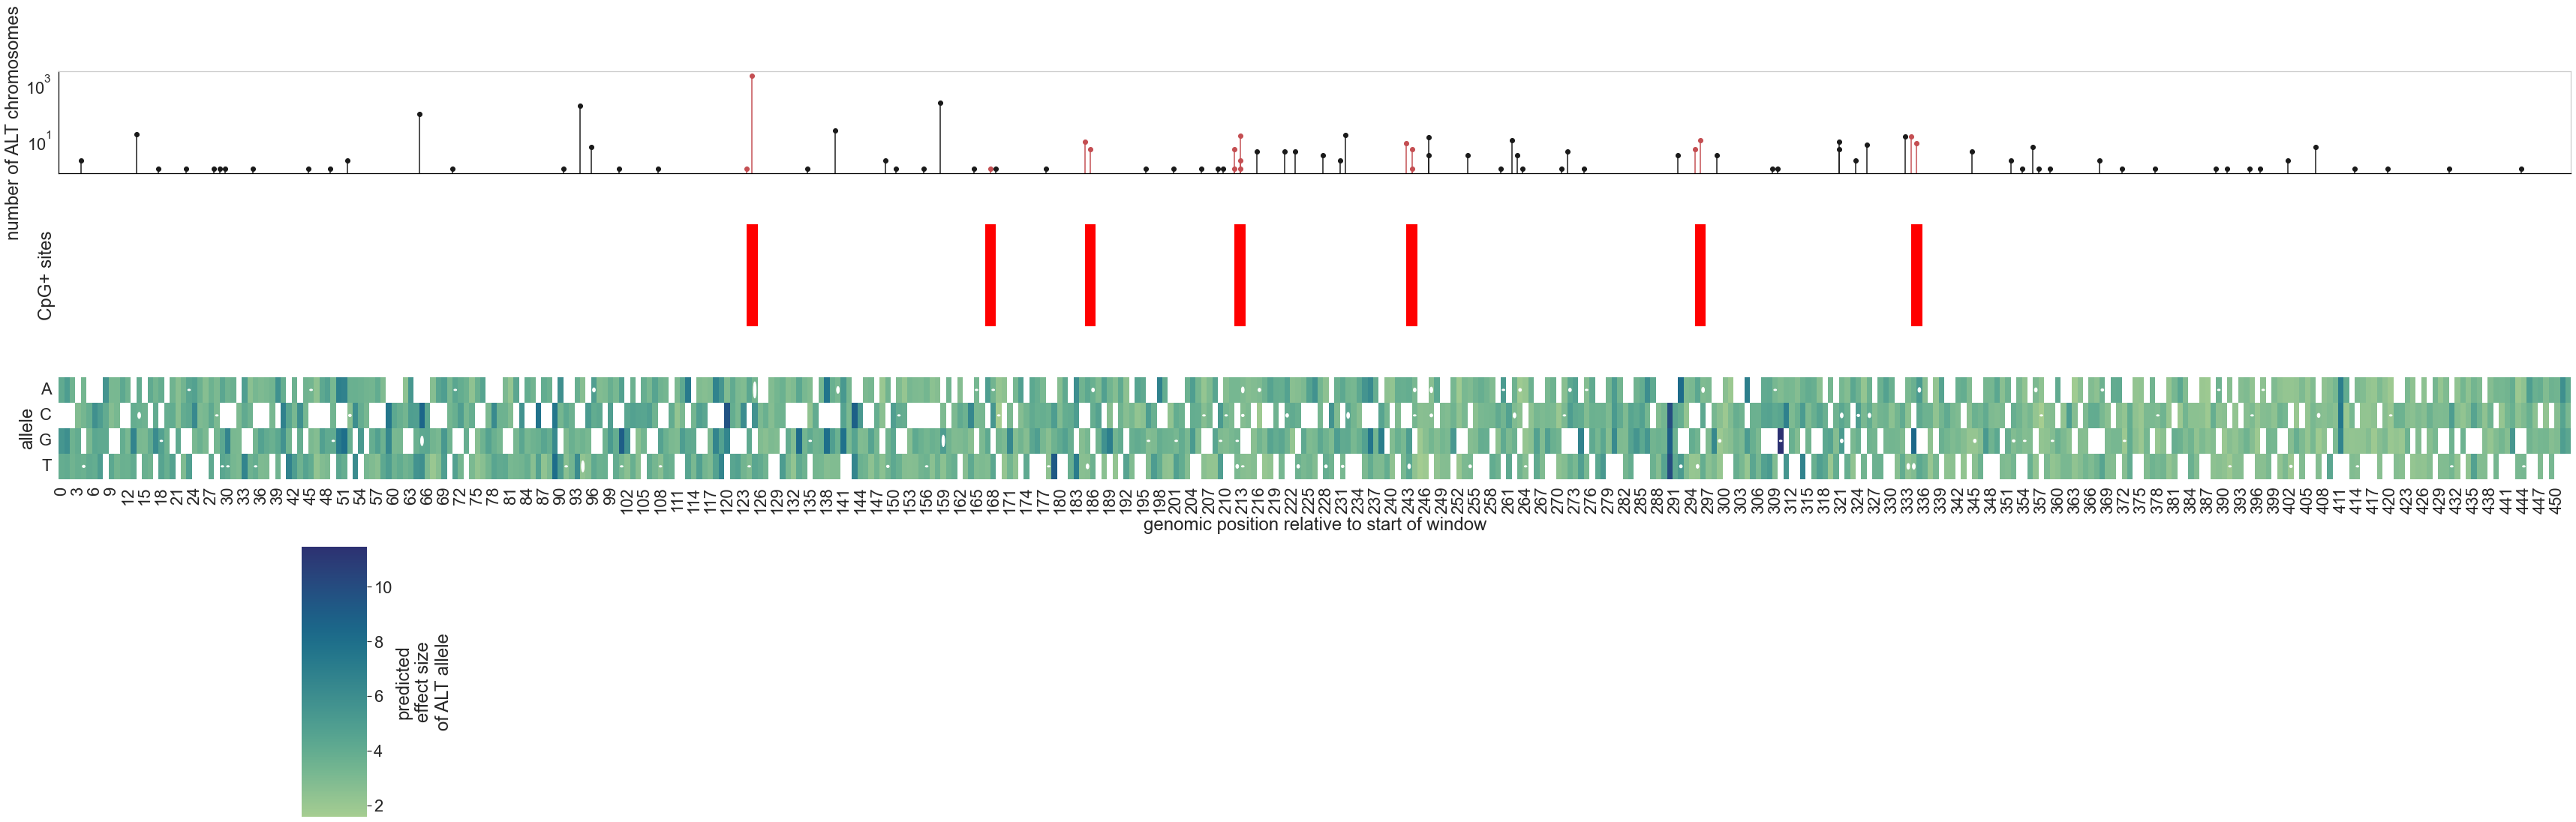

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

plt.rcParams.update({
  'axes.facecolor': 'white'
})

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

def plot_stem(ax, SNVs, xlim): 
  x = [SNV['position_offset'] for SNV in SNVs]
  y = [SNV['number_ALT_chromosomes'] for SNV in SNVs]
  CpG = [SNV['CpG+'] for SNV in SNVs]  

  x = np.array(x)
  y = np.array(y)

  ax.stem(x[CpG], y[CpG], linefmt='r-', markerfmt='ro')  
  ax.stem(x[np.logical_not(CpG)], y[np.logical_not(CpG)], linefmt='k-', markerfmt='ko')  
  ax.set_yscale('log')
  ax.set_xlim(xlim) 
  ax.spines['bottom'].set_color('black')
  ax.spines['left'].set_color('black')
  # ax.set_xlabel('genomic position of SNV relative to start of window')
  ax.set_ylabel('number of ALT chromosomes')
  ax.xaxis.set_tick_params(labelbottom=False)

def create_ellipse(SNV): 
  x = SNV['position_offset'] + 0.5
  y = BASES.index(SNV['ALT']) + 0.5
  log_ALT_count_plus_one = np.log10(SNV['number_ALT_chromosomes']+1)
  log_max_ALT_count_plus_one = np.log10(SNV['number_chromosomes']+1)
  return Ellipse(
    (x,y), 
    width=0.5, 
    height=log_ALT_count_plus_one/log_max_ALT_count_plus_one,
    color='white'
  )

def plot_heat_map(heat_map, mask, ax, fig, xlim): 
  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
  sns.heatmap(
      heat_map, 
      ax = ax,
      cmap = sns.color_palette("crest", as_cmap=True), # https://seaborn.pydata.org/tutorial/color_palettes.html
      center = None, 
      annot = False, 
      # fmt = '.3f',
      # linewidths = 1, 
      cbar = True,
      cbar_ax = fig.add_axes([0.2, -0.5, 0.02, 0.5]),
      cbar_kws = {'label': 'predicted\neffect size\nof ALT allele'},
      mask = np.logical_not(mask)
  )
  # ax.invert_yaxis()
  ax.set_yticks(np.arange(len(BASES))+0.5)
  ax.set_yticklabels(list(BASES), rotation=0)
  ax.set_xlabel('genomic position relative to start of window')
  ax.set_ylabel('allele')
  ax.set_xlim(xlim)

def plot_ellipses(SNVs, ax):
  ellipses = [create_ellipse(SNV) for SNV in SNVs]
  # https://stackoverflow.com/a/71675432 : 
  p = PatchCollection(ellipses, alpha=1, match_original=True)
  ax.add_collection(p)
  
def plot_CpG_sites(CpG_sites, ax, xlim): 
  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
  sns.heatmap(
      CpG_sites, 
      ax = ax,
      cmap = ['white','red'], # sns.color_palette("crest", as_cmap=True), # https://seaborn.pydata.org/tutorial/color_palettes.html
      center = None, 
      annot = False, 
      # fmt = '.3f',
      # linewidths = 1, 
      cbar = False,
      # cbar_ax = fig.add_axes([0.6, -0.5, 0.02, 0.5]),
      # cbar_kws = {'label': 'CpG+'},
      mask = None
  )
  ax.set_xlim(xlim)
  ax.set_yticks([])
  ax.set_ylabel('CpG+ sites')

def plot_snvs_and_variant_effects(window_index, threshold_heat_map, xlim, figsize, font_scale): 
  window = fetch_window(window_index)
  embeddings = fetch_embeddings(window_index)

  SNVs = get_snvs(window)
  heat_map, mask = compute_heat_map(window, embeddings)

  if threshold_heat_map: 
    heat_map[heat_map<EFFECT_SIZE_THRESHOLD] = 0 # type: ignore
    heat_map[heat_map>EFFECT_SIZE_THRESHOLD] = 1 # type: ignore

  sns.set(font_scale=font_scale)
  # set background color to white
  sns.set_style("whitegrid", {'axes.grid' : False})
  
  fig, axes = plt.subplots(3, 1, sharex=True, figsize=figsize)
  plot_stem(axes[0], SNVs, xlim)  
  plot_CpG_sites(compute_CpG_sites(window), axes[1], xlim)
  plot_heat_map(heat_map, mask, axes[2], fig, xlim)
  plot_ellipses(SNVs, axes[2])
  fig.subplots_adjust(hspace=0.5)
  
plot_snvs_and_variant_effects(window_index=23, threshold_heat_map=False, xlim=None, figsize=(60, 10), font_scale=2)

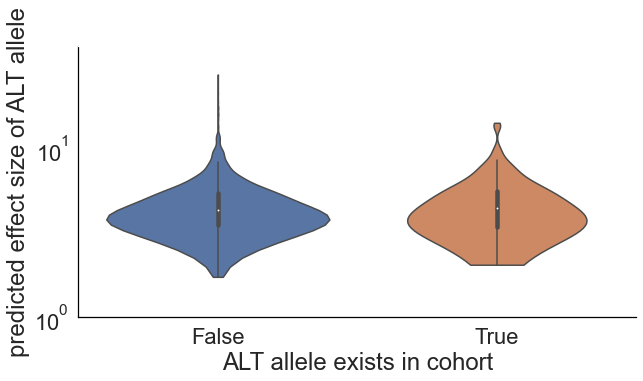

In [7]:
sns.set(font_scale=2)

plt.rcParams.update({
  'figure.figsize': (10, 5),
  'axes.facecolor': 'white'
})

from ravel_unravel import ravel

def compute_ALT_effects_and_existence(window_index): 
  window = fetch_window(window_index)
  number_sites = int(window['end']) - int(window['start'])

  SNVs = get_snvs(window)

  SNV_present = np.zeros(shape=(len(BASES), number_sites))
  for SNV in SNVs: 
    site_index = SNV['position_offset']
    if site_index >= number_sites: continue
    ALT_index = BASES.index(SNV['ALT'])
    SNV_present[ALT_index, site_index] = 1 

  embeddings = fetch_embeddings(window_index)
  heat_map, mask = compute_heat_map(window, embeddings)

  SNV_present = ravel(SNV_present)
  heat_map = ravel(heat_map)
  mask = ravel(mask)

  mask = np.array(mask, dtype=bool)
  ALT_effect_size = heat_map[mask]
  ALT_exists_in_cohort = SNV_present[mask]
  ALT_exists_in_cohort = np.array(ALT_exists_in_cohort, dtype=bool)

  return ALT_effect_size, ALT_exists_in_cohort

def correlate_snvs_and_variant_effects(window_index): 
  ALT_effect_size, ALT_exists_in_cohort = compute_ALT_effects_and_existence(window_index)

  sns.violinplot(
    x = ALT_exists_in_cohort, 
    y = ALT_effect_size,     
    scale = "area", # each violin will have the same area
    cut = 0, # Prevent the density from smoothing beyond the limits of the data
  )
  plt.yscale('log')
  plt.ylim([1, 40])
  plt.xlabel('ALT allele exists in cohort')
  plt.ylabel('predicted effect size of ALT allele')
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.show()

correlate_snvs_and_variant_effects(window_index=0)

## Aggregate windows 

In [8]:
def aggregate(): 
  number_windows = 100

  ALT_effect_size_all_windows = [] 
  ALT_exists_in_cohort_all_windows = [] 
  for window_index in range(number_windows):
    ALT_effect_size, ALT_exists_in_cohort = compute_ALT_effects_and_existence(window_index)
    ALT_effect_size_all_windows.extend(ALT_effect_size)
    ALT_exists_in_cohort_all_windows.extend(ALT_exists_in_cohort)

  ALT_effect_size_all_windows = np.array(ALT_effect_size_all_windows)
  ALT_exists_in_cohort_all_windows = np.array(ALT_exists_in_cohort_all_windows, dtype=bool)    

  return ALT_effect_size_all_windows, ALT_exists_in_cohort_all_windows

ALT_EFFECT_SIZE, ALT_EXISTS_IN_COHORT = aggregate()

## Test for negative selection

negative selection


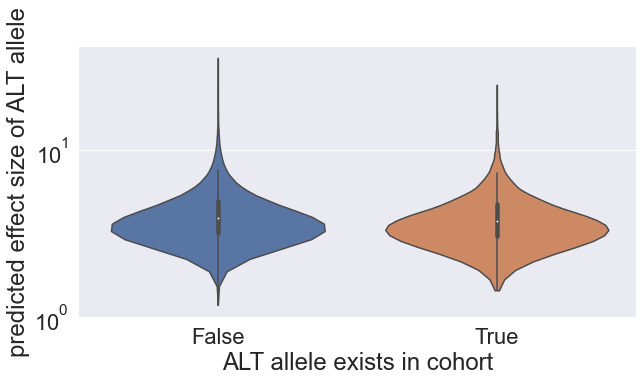

effect_size_threshold: 2.0
[[221315  16214]
 [  1577    192]] 1.6618438593075697 3.5023288542406564e-10
effect_size_threshold: 3.0
[[180010  12618]
 [ 42882   3788]] 1.260204559772408 2.901391611522297e-32
effect_size_threshold: 4.0
[[104544   6882]
 [118348   9524]] 1.2224832243737669 4.2757830539921263e-35
effect_size_threshold: 5.0
[[ 54093   3411]
 [168799  12995]] 1.2208597139594446 9.51252873626803e-25
effect_size_threshold: 6.0
[[ 28928   1799]
 [193964  14607]] 1.210952597187453 1.779278752327693e-14
effect_size_threshold: 7.0
[[ 16560   1005]
 [206332  15401]] 1.2299192635778131 1.3365639768164482e-10
effect_size_threshold: 8.0
[[ 10119    595]
 [212773  15811]] 1.2637566441088615 1.0795465348970869e-08
effect_size_threshold: 9.0
[[  6446    381]
 [216446  16025]] 1.2526040148994386 7.603643463071785e-06
effect_size_threshold: 10.0
[[  4222    261]
 [218670  16145]] 1.1943361180189467 0.002609955579679603
effect_size_threshold: 11.0
[[  2857    185]
 [220035  16221]] 1.1384772

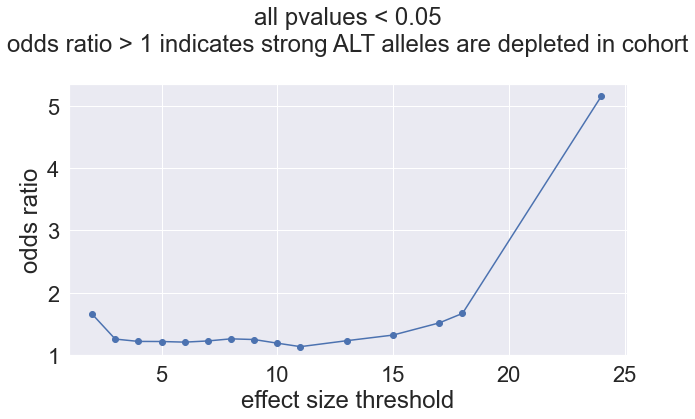

In [9]:
from scipy.stats import fisher_exact
  
plt.rcParams.update({
  'figure.figsize': (10, 5),
})

sns.set(font_scale=2)

def plot_enrichment_in_strong_alleles(test='negative selection'):
  print(test)

  sns.violinplot(
    x = ALT_EXISTS_IN_COHORT,
    y = ALT_EFFECT_SIZE,     
    scale = "area", # each violin will have the same area
    cut = 0, # Prevent the density from smoothing beyond the limits of the data
  )
  plt.yscale('log')
  plt.xlabel('ALT allele exists in cohort')
  plt.ylabel('predicted effect size of ALT allele')
  plt.show()

  effect_size_thresholds = [] 
  odds_ratios = []
  pvalues = []
  pvalue_threshold = 0.05
  for effect_size_threshold in np.arange(2, np.max(ALT_EFFECT_SIZE), 1):
    print(f'effect_size_threshold: {effect_size_threshold}')
  
    ALT_is_strong = ALT_EFFECT_SIZE>effect_size_threshold

    if test == 'negative selection': 
      table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), ALT_EXISTS_IN_COHORT))
    elif test == 'positive selection': 
      table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), np.logical_not(ALT_EXISTS_IN_COHORT)))
    else: 
      raise ValueError    
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
    result = fisher_exact(table, alternative='greater')
    odds_ratio, pvalue = result.statistic, result.pvalue # type: ignore

    if pvalue > pvalue_threshold: continue 

    print(table, odds_ratio, pvalue)

    effect_size_thresholds.append(effect_size_threshold)
    odds_ratios.append(odds_ratio)
    pvalues.append(pvalue)

  plt.plot(effect_size_thresholds, odds_ratios, 'o-')
  plt.xlim([1, None])
  plt.ylim([1, None])
  plt.xlabel('effect size threshold')
  plt.ylabel('odds ratio')
  if test == 'negative selection':
    plt.title(
      f'all pvalues < {pvalue_threshold}\n'
      'odds ratio > 1 indicates strong ALT alleles are depleted in cohort\n'
    )
  plt.show()

plot_enrichment_in_strong_alleles()